## INTRODUCTION : 

This notebook contains the main code used in the first part of the paper (GFP diffusion with one receptor, and no signaling).

It is divided in two sections:

The first section shows simulations results obtained with the parameters from the fit. 

The second section describes the method used to fit parameters to the experimental data (Nelder-Mead minimization to obtain parameters, and bootstrapping method to evaluate their reliability).

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:

#import packages : 

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import os
import sys 
import random
from scipy.optimize import minimize

##import experimental data  : 

dir='./Experimental_Data'

#import data from high affinity nanobody (VHH)  experiment
vhh=pd.read_csv(dir+'/hh-VHH-CD8.csv')
col = vhh.loc[: , "1":"11"]
vhh['signal_mean'] = col.mean(axis=1)
vhh['signal_std'] = col.std(axis=1)

#import data from high affinity nanobody + fat body trap experiment

fat_body=pd.read_csv(dir+'/20190712 ptc-sGFP hh-VHH-CD8, lpp>VHH-CD8.csv')
col = fat_body.loc[: , "1":"7"]
fat_body['signal_mean'] = col.mean(axis=1)
fat_body['signal_std'] = col.std(axis=1)


#import data from high affinity nanobody overexpression  experiment

vhh_gal4=pd.read_csv(dir+'/20190709 ptc-sG hhG4 UAS-VHH-CD8_copy_pandas.csv')
col = vhh_gal4.loc[: , "sample1":"sample8"]
vhh_gal4['signal_mean'] = col.mean(axis=1)
vhh_gal4['signal_std'] = col.std(axis=1)

#import data from low affinity nanobody experiment
lag3=pd.read_csv(dir+'/20190307 ptc-sG hh-LaG3-CD8.csv')
col = lag3.loc[: , "1":"10"]
lag3['signal_mean'] = col.mean(axis=1)
lag3['signal_std'] = col.std(axis=1)

In [4]:
#Typical data table : 
vhh.head(5)

,distance,1,2,3,4,5,6,7,8,9,10,11,signal_mean,signal_std
0,0.000,1.980460,2.046955,1.905768,1.779641,2.111069,2.002404,1.713182,1.712666,2.015716,1.847048,1.760173,1.897735,0.142587
1,0.379,2.183095,2.289465,1.943747,1.794173,2.233780,2.012807,1.817485,1.875941,2.175123,2.196811,2.028036,2.050042,0.175785
2,0.758,2.370211,2.462151,1.873085,1.853783,2.308227,2.093152,1.946044,2.052274,2.397054,2.388833,2.167073,2.173808,0.224033
3,1.137,2.432055,2.472848,1.947139,1.916822,2.419099,2.311189,2.046759,2.227974,2.609710,2.440612,2.258509,2.280247,0.227025
4,1.517,2.402709,2.390250,2.150277,2.036248,2.494102,2.541499,2.094595,2.262136,2.692556,2.617154,2.217941,2.354497,0.218872


Experimental data is taken from n=7 (corresponding to 2.65 um), as the initial increase observed in concentration is attributed to imprecision on the detection of the location of the AP boundary. Therefore we assume here that the end of the source and the beginning of the tissue occurs at this point.
n=7 has been chosen from VHH data and is then applied to all experimental data.

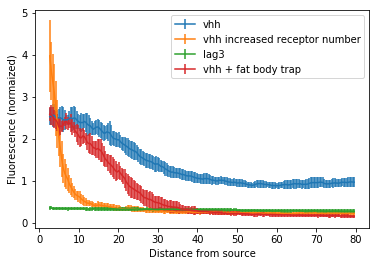

In [5]:
#Plot experimental data : 
plt.figure();
plt.errorbar(vhh['distance'][7:211],
             vhh['signal_mean'][7:211],
             yerr=vhh['signal_std'][7:211])
plt.errorbar(vhh_gal4['distance'][7:211],
             vhh_gal4['signal_mean'][7:211],
             yerr=vhh_gal4['signal_std'][7:211])
plt.errorbar(lag3['distance'][7:211],
             lag3['signal_mean'][7:211],
             yerr=lag3['signal_std'][7:211])
plt.errorbar(fat_body['distance'][7:211],
             fat_body['signal_mean'][7:211],
             yerr=fat_body['signal_std'][7:211])
plt.legend(['vhh',
            'vhh increased receptor number',
            'lag3',
            'vhh + fat body trap'])
plt.ylabel('Fluorescence (normaized)')
plt.xlabel('Distance from source')
plt.show()

## Part 1 : Simulations of gradient formation and figures : 

In [6]:
## Simulating gradient formation : 
#domain size (in um)
L = 116
#size of the source (in um)
source_size_value = 26
#number of points within the domain
nb_x_points = 400
#array of values of x positions
#one takes nb_x_points+1, assuming that nb_x_points is even, to make sure
#that the point 0 is included in the array.
#also round up by 12 decimals to make sure that 0 is at 0.
x_array = np.around(np.linspace(-(1.0 - 1.0 / 2.0/ float(nb_x_points)) * L,
                      (1.0 - 1.0 / 2.0/ float(nb_x_points)) * L,
                      nb_x_points+1),
                    12)
#define a set of masks which are useful to solve the equations.
mask_tissue_posterior = x_array >= 0
mask_tissue_anterior = x_array < - source_size_value
mask_source = (x_array >=-source_size_value) &(x_array <0)
#spatial resolution
delta_x = x_array[1]-x_array[0]
#define a function that will return the time evolution of the concentration profile
def dcdt_function(c_array,
                  t,
                  J,
                  D,
                  h,
                  k_on,
                  k_off,
                  jr,
                  kappa_H,
                  source_size,
                  k_H):
    """Differential equations for the concentration equation, discretized in x,
    and for the evolution of the source concentration.
    c_array is the current concentration profile,
    t is the time point
    J is the influx from the source
    D is the diffusion constant
    h is the size of the intercellular space
    k_on is the on rate to receptors
    k_off is the off rate from receptors
    jr is the product of k, the effective degradation rate,
    and nT, the total density of receptors
    kappa_H is the exchange rate between tissue and hemolymph
    source_size is the length of the source
    k_H is the degradation rate in the hemolymph
    """
    #cH is the concentration in the hemolymph
    #here always assumed to be at equilibrium
    cH = kappa_H * np.mean(c_array)/(kappa_H + k_H)
    #calculate second derivative, imposing boundary conditions on the first derivative
    #on the left the derivative is imposed to vanish
    #on the right the derivative is imposed to vanish
    cxx = np.zeros(len(c_array))
    cxx[1:-1] = (c_array[2:]+c_array[0:-2] - 2.0 * c_array[1:-1]) / (delta_x**2)
    cxx[0] = (c_array[1]-c_array[0]) / (delta_x**2)
    cxx[-1] = (c_array[-2]-c_array[-1]) / (delta_x**2)
    # Compute dc/dt, the change of concentration
    dcdt_vector = np.zeros(len(x_array))
    dcdt_vector[mask_source] = (D * cxx[mask_source]
                                + J
                                - kappa_H * (c_array[mask_source] - cH))
    dcdt_vector[mask_tissue_posterior] =  (D * cxx[mask_tissue_posterior]
                                          - 1.0 / h * k_on
                                           * jr *c_array[mask_tissue_posterior] 
                                          /(k_off + k_on * c_array[mask_tissue_posterior])
                                          - kappa_H *
                                           (c_array[mask_tissue_posterior] - cH))
    dcdt_vector[mask_tissue_anterior] =  (D * cxx[mask_tissue_anterior]
                                          - kappa_H *
                                          (c_array[mask_tissue_anterior] - cH))
    #return the vector dc/dt 
    return dcdt_vector

In [7]:
#Set parameters : 

#from litterature : 
#diffusion constant in um/s^2
D_value = 21 
#size of intercellular space in um
h_value = 0.02 
# on rate for the high affinity nanobody, in /nM/s
k_on_value = 7.7 * 10 **(-4) 
# off rate for the high affinity nanobody, in /s
k_off_value = 1.7 * 10 ** (-4) 
# on rate for the low affinity nanobody,in /nM/s
k_on_value_LAG3 = 2 * 10 ** (-3) 
# off rate for the low affinity nanobody, in /s
k_off_value_LAG3 = 5 * 10 ** (-2) 


#from fit (see part2)# : 

 #influx from the source in nM/s
J_value = 0.30
#product of degradation rate and receptor density in nM.um/s
jr_value = 2.6e-3 
#exchange rate between tissue and hemolymph, in /s
kappa_H_value = 0.075 
#effective degradation rate in the haemolymph, in /s
k_H_value = 0.01 
#effective degradation rate in the haemolymph in the fat body trap experiment, in /s
k_H_fat_body_value = 0.19




To accelerate the search for the steady-state, define a function which obtains the analytical steady-state solution when saturation is ignored.

In [8]:
def calculate_approximate_analytical_solution(J,
                                              D,
                                              h,
                                              k_on,
                                              k_off,
                                              jr,
                                              kappa_H,
                                              source_size,
                                              k_H):

    k_r = jr/h * k_on/(k_off)
    ell = np.sqrt(D/(k_r+kappa_H))
    ell_0 = np.sqrt(D/kappa_H)
    cH = J/L *(source_size - (ell_0-ell)*(1-np.exp(-source_size/ell_0)))/(2*k_H + k_r * kappa_H/(kappa_H+k_r))
    c0 = ell/kappa_H/(ell+ell_0) *(cH * kappa_H * k_r/(kappa_H+ k_r) + J *(1- np.exp(-source_size / ell_0)))
    C_1 = c0 + J / 2.0 / kappa_H * (-2.0 + np.exp(-source_size / ell_0)) - cH * k_r/(k_r+kappa_H)
    C_2 = - J /2.0 / kappa_H * np.exp(-source_size /ell_0)
    C_3 =  ((-J * (k_r + kappa_H) + kappa_H * (-cH * k_r 
                                             + c0 * (k_r+kappa_H)) 
                                             + J * (k_r + kappa_H) * np.cosh(source_size/ell_0)
                                             )
            /(kappa_H * (k_r + kappa_H))
            )
    initial_condition = np.zeros(len(x_array))
    initial_condition[mask_tissue_posterior] = c0 * np.exp(-x_array[mask_tissue_posterior] / ell) + cH * kappa_H/(kappa_H+k_r)
    initial_condition[mask_tissue_anterior] = cH + C_3 * np.exp(x_array[mask_tissue_anterior] / ell_0)
    initial_condition[mask_source] = (cH + J/kappa_H+
                                             C_1 * np.exp(x_array[mask_source] / ell_0) + 
                                             C_2 * np.exp(-x_array[mask_source] / ell_0)
                                             )
    return(initial_condition)

In [9]:
def predicted_bound_GFP_function(x_data,
                                 c_data,
                                 J,
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision):
    #"precision" stops the simulation if a steady state has been reached,
    # defined as a small change occurring in 500s.
    time_0 = 500
    nb_time_points = 20
    pseudo_time_array = np.linspace(0, time_0, nb_time_points)
    #set-up an initial condition which is approximately correct to
    #accelerate the fit
    initial_condition = calculate_approximate_analytical_solution(J,
                                         D,
                                         h,
                                         k_on,
                                         k_off,
                                         jr,
                                         kappa_H,
                                         source_size,
                                         k_H)
    # calculate the profile of free GFP
    sol = odeint(dcdt_function,
                 initial_condition,
                 pseudo_time_array,
                 args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                 )
    sol1=sol[-1, :]
    sol2=sol[-2, :]
    j=0
    while np.mean(np.square(sol1/sol2-1))>precision : 
        j+=1
        pseudo_time_array = np.linspace((j-1)*time_0, j*time_0, nb_time_points)
        sol = odeint(dcdt_function,
                     sol1,
                     pseudo_time_array,
                     args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                     )
        sol1=sol[-1, :]
        sol2=sol[-2, :]
    final_sol_free_GFP = sol[-1, :]
    #posterior = where the receptors are expressed
    mask_tissue_posterior = x_array >= 0
    final_sol_bound_GFP=np.zeros_like(final_sol_free_GFP)
    # from the profile of free GFP, calculate the profile of bound GFP
    final_sol_bound_GFP[mask_tissue_posterior] = (k_on * 
                                                  nT_value * 
                                                  final_sol_free_GFP[mask_tissue_posterior]
                                                  /(k_off 
                                                    + k_on 
                                                    * final_sol_free_GFP[mask_tissue_posterior]))
    
    #The global variable nT is just a scaling factor.
    #By setting it to 1, this function returns the normalized 
    #profile of bound receptors nb/nT. 
    #For special cases where the total number of receptors varies we change nT.
    
    #Finally interpolate on the x experimental grid.
    predicted_bound_GFP = np.interp(x_data, x_array, final_sol_bound_GFP)
    return predicted_bound_GFP

In [21]:
precision=1e-12
nT_value = 1
#simulate the vhh experiment 
result_vhh =\
predicted_bound_GFP_function(vhh['distance'][7:]-vhh['distance'][7],
                             vhh['signal_mean'][7:],
                             J_value,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_value,
                             precision) 
#simulate fat body experiment 
result_fat_body =\
predicted_bound_GFP_function(fat_body['distance'][7:299]-fat_body['distance'][7],
                             fat_body['signal_mean'][7:299],
                             J_value,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_fat_body_value,
                             precision)

#simulate experiment where the nanobody is now lag3
result_lag3 =\
predicted_bound_GFP_function(lag3['distance'][7:295]-lag3['distance'][7],
                             lag3['signal_mean'][7:295],
                             J_value,
                             D_value,
                             h_value,
                             k_on_value_LAG3,
                             k_off_value_LAG3,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_value,
                             precision)
#simulating an increase of receptors 
#the number of receptors is increased by approx. 20 fold:
nT_value = 20*nT_value
result_wall=\
predicted_bound_GFP_function(vhh_gal4['distance'][7:295]-vhh_gal4['distance'][7],
                             vhh_gal4['signal_mean'][7:295],
                             J_value,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             20*jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_value,
                             precision)

## Fig 2.B : Typical profiles produced by the model 

J value for plot:  0.0003


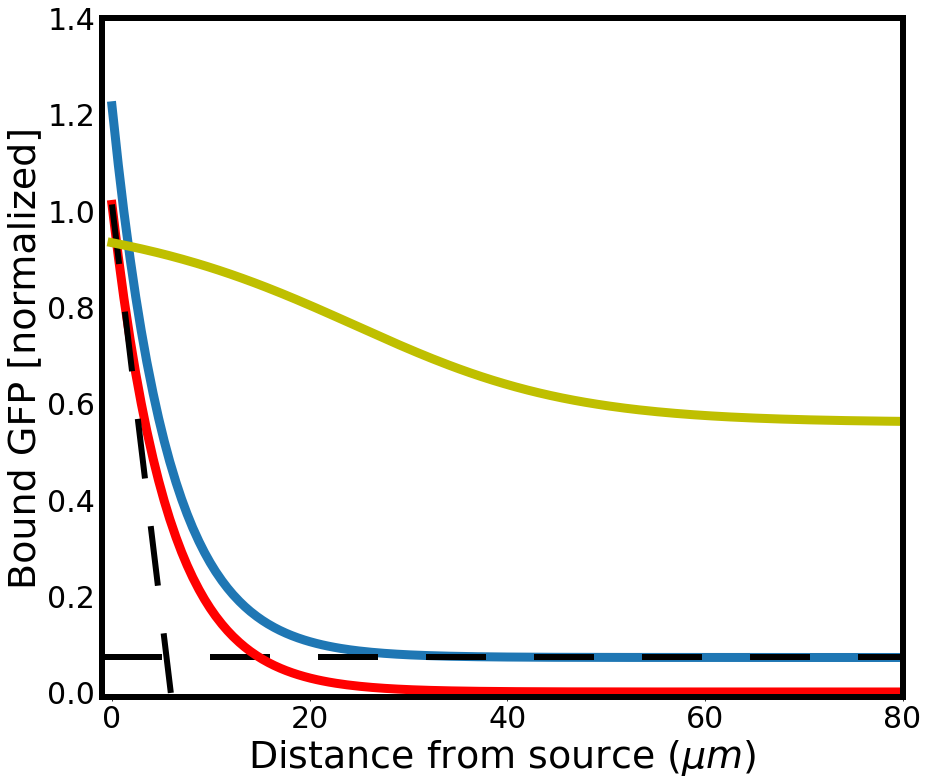

characteristic length, method 1: 5.945018526107129
characteristic length, method 2: 5.628900462622451


In [33]:
nT_value = 1
#increasing the production of GFP results in saturation of receptors
J_value_for_plot = 0.5
x_array_for_plot = np.linspace(0, 80, 1000)
delta_x_for_plot = x_array_for_plot[1] - x_array_for_plot[0]
result_sat =\
predicted_bound_GFP_function(x_array_for_plot ,
                             vhh['signal_mean'][7:],
                             J_value_for_plot,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_value,
                             precision)
#for low GFP production the profile is exponential
#scaling factor for curves to have similar sizes
nT_value = 300
J_value_for_plot = 0.001 * J_value
print('J value for plot: ', J_value_for_plot)
result_no_sat=\
predicted_bound_GFP_function(x_array_for_plot ,
                             vhh['signal_mean'][7:],
                             J_value_for_plot,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_value,
                             precision)
#final value, to plot horizontal line illustrating the
#existence of the plateau.
final_value_no_sat = result_no_sat[-1]
#Full degradation of GFP in the hemolymph suppreses the plateau : 
kh_inf=k_H_value * np.inf
result_no_hem=\
predicted_bound_GFP_function(x_array_for_plot ,
                             vhh['signal_mean'][7:],
                             J_value_for_plot,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             kh_inf,
                             precision)
#initial value and initial slope to plot a line
initial_value_no_hem = result_no_hem[0]
slope_value_no_hem = (result_no_hem[1]-result_no_hem[0])/(delta_x_for_plot)
plt.figure(figsize = (13,11))
ax2=plt.gca()
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.plot(x_array_for_plot,
         result_no_sat,
         lw=9,
         ms = 10)
plt.axhline(y=final_value_no_sat,
            color='black',
            linestyle='--',
            dashes=(10, 8),
            lw=6)
plt.plot(x_array_for_plot,
         result_no_hem,
         'r',
         lw=9,
         ms = 10)
plt.plot(x_array_for_plot ,
         (initial_value_no_hem 
         + slope_value_no_hem 
          *(x_array_for_plot )),
         color='black',
            linestyle='--',
            dashes=(10, 8),
            lw=6
         )
plt.plot(x_array_for_plot ,
         result_sat,
         'y',
         lw=9,
         ms = 10)
plt.ylim([-0.01,1.40])
plt.xlim([-1,80])
plt.ylabel(r"Bound GFP [normalized]",fontsize =38)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =38)
plt.tick_params(labelsize=30)
plt.tight_layout()    

for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
plt.savefig('./Figures/fig_2B.eps',format='eps',dpi=600)
plt.show()
#evaluate characteristic length of the exponential for the no sat, no hem case by 2 methods
#results are slightly different because of grid resolution
#ok for illustration
print('characteristic length, method 1:', 1.0/(-slope_value_no_hem/initial_value_no_hem ))
print('characteristic length, method 2:', 1.0/(np.mean(-np.diff(np.log(result_no_hem))/(delta_x_for_plot))))

## Figure 2C : main curves obtained after fit.

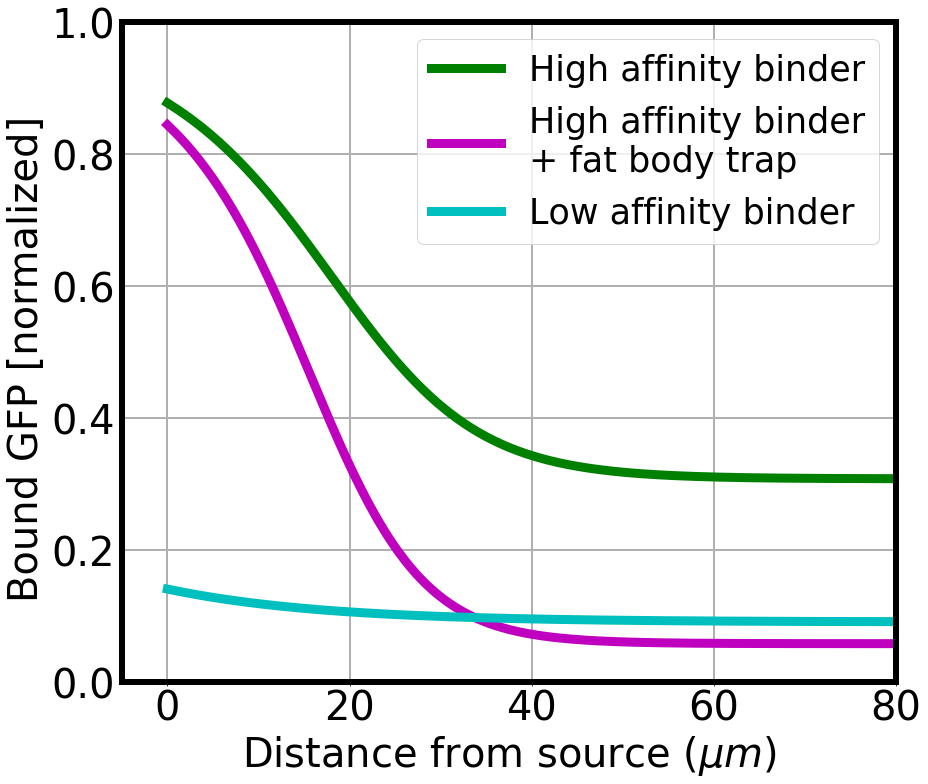

In [12]:
f=plt.figure(figsize = (13,11))
ax1 = plt.subplot(111)
ax1.plot(vhh['distance'][7:]-vhh['distance'][7],
         result_vhh,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "g")
ax1.plot(fat_body['distance'][7:299]-fat_body['distance'][7],
         result_fat_body,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "m")
ax1.plot(lag3['distance'][7:295]-lag3['distance'][7],
         result_lag3,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "c")
y1min= 0
y1max=1
ax1.set_xlim(-5,80)
ax1.set_ylim(y1min,y1max)
plt.tick_params(labelsize=30)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(6)
plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =40)
plt.yticks([0, 0.2,0.4,0.6,0.8,1.0])
plt.tick_params(labelsize=40)
plt.legend(['High affinity binder',
            'High affinity binder\n+ fat body trap',
            'Low affinity binder' ],
           fontsize=35)
plt.grid(lw=2)
plt.tight_layout()
plt.savefig('./Figures/fig_2C.eps',format='eps',dpi=600)
plt.show()

## Figure 3A :  Effect of increasing the number of receptors :


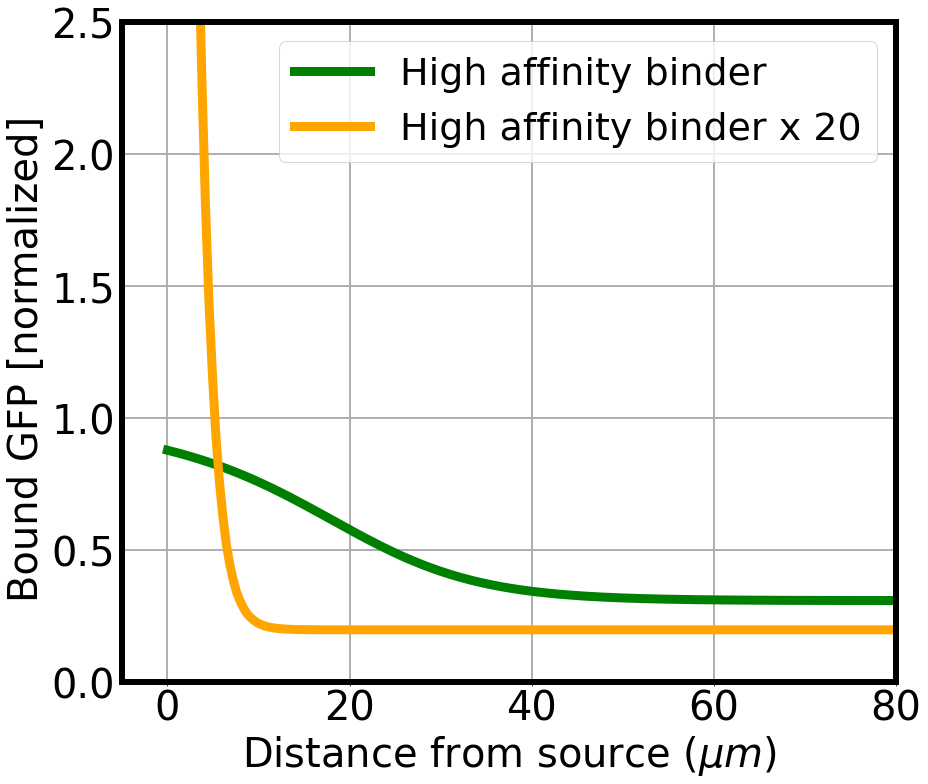

In [13]:
f2=plt.figure(figsize = (13,11))
ax2 = plt.subplot(111)
ax2.plot(vhh['distance'][7:]-vhh['distance'][7],
         result_vhh,
         lw=9,
         ms = 10,
         color = "g")
ax2.plot(vhh_gal4['distance'][7:295]-vhh_gal4['distance'][7],
         result_wall,
         lw=9,
         ms = 10,
         color='orange')
y2min= 0
y2max=2.5
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
ax2.set_xlim(-5,80)
ax2.set_ylim(y2min,y2max)
plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =40)
plt.tick_params(labelsize=40)
plt.legend([r'High affinity binder',
            r'High affinity binder x 20'],
           fontsize=38)
plt.grid(lw=2)
plt.tight_layout()
plt.savefig('./Figures/fig_3A.eps',format='eps',dpi=600)
plt.show()

## Figure S5H-I : Effect of changing kon 


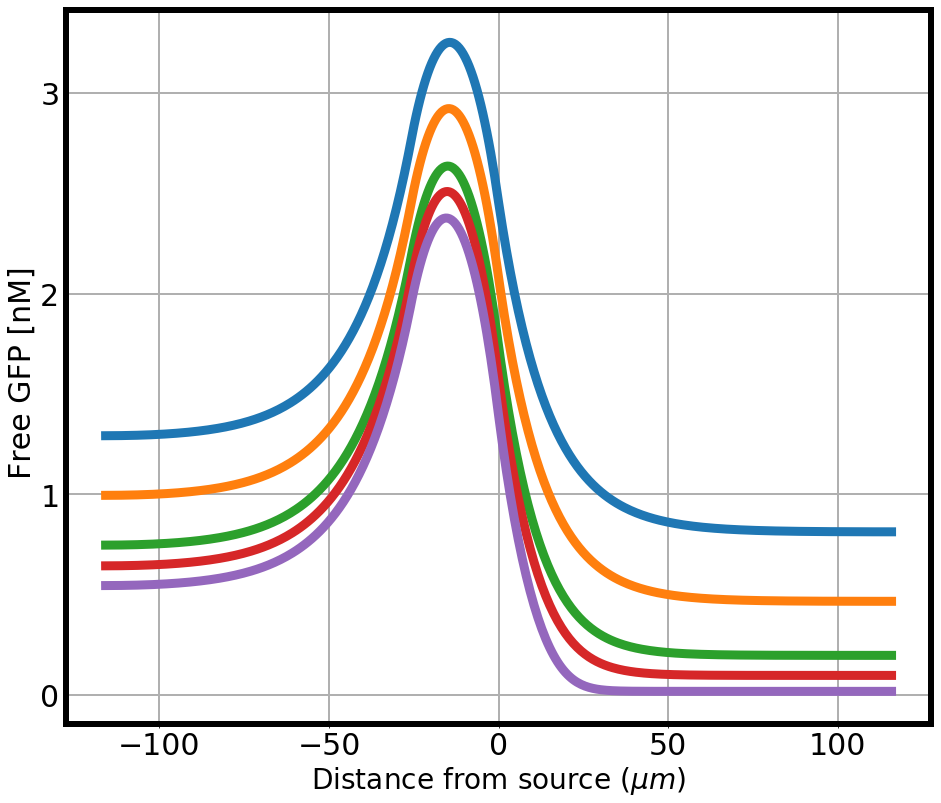

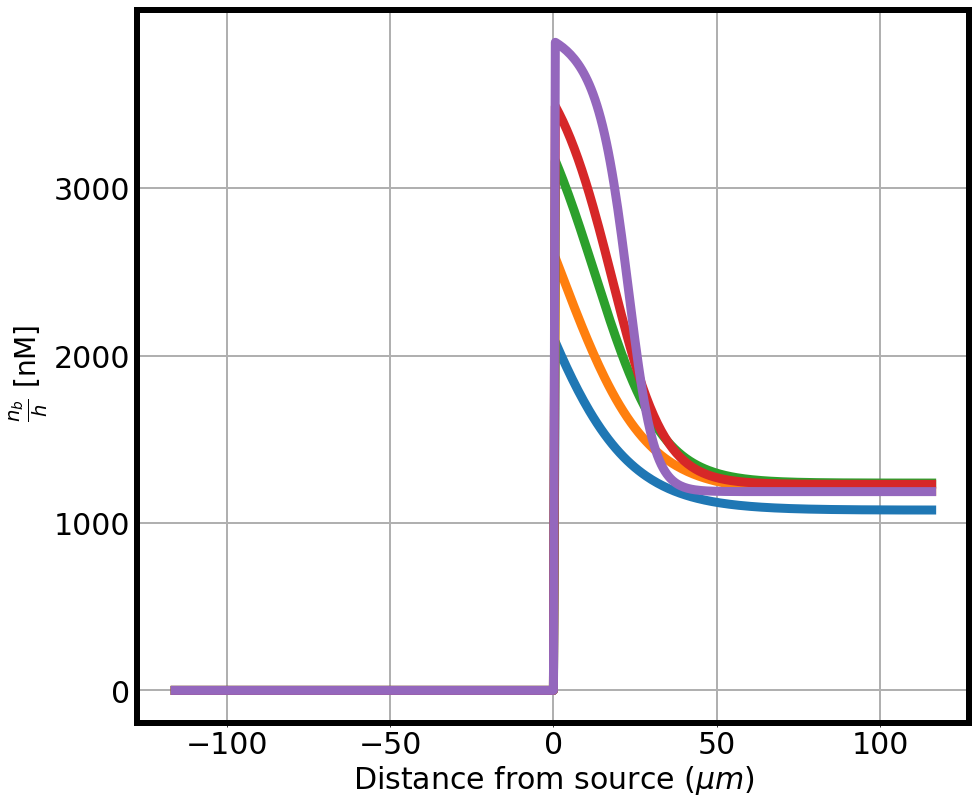

In [37]:
#receptor surface density, in nM.um
nT_value = 80
def predicted_bound_and_free_GFP_function(J,
                                           D,
                                           h,
                                           k_on,
                                           k_off,
                                            jr,
                                           kappa_H,
                                           source_size,
                                            k_H):
    time_0 = 500
    nb_time_points = 20
    pseudo_time_array = np.linspace(0, time_0, nb_time_points)
    initial_condition = np.zeros(len(x_array))
    # calculate the profile of free GFP
    sol = odeint(dcdt_function,
                 initial_condition,
                 pseudo_time_array,
                 args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                 )
    sol1=sol[-1, :]
    sol2=sol[-2, :]
    j=0
    while np.mean(np.square(sol1/sol2-1))>precision : 
        j+=1
        pseudo_time_array = np.linspace((j-1)*time_0, j*time_0, nb_time_points)
        sol = odeint(dcdt_function,
                 sol1,
                 pseudo_time_array,
                 args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                 )
        sol1=sol[-1, :]
        sol2=sol[-2, :]
        
    sol_free_GFP = sol
    #posterior = where the receptors are expressed
    mask_tissue_posterior = x_array > 0
    sol_bound_GFP = np.zeros_like(sol_free_GFP)
    # from the profile of free GFP, calculate the profile of bound GFP
    for i, this_free_profile_GFP in enumerate(sol_free_GFP):
        sol_bound_GFP[i, mask_tissue_posterior] =\
        (k_on *
         nT_value *
         this_free_profile_GFP[mask_tissue_posterior]
         /(k_off 
          + k_on
         * this_free_profile_GFP[mask_tissue_posterior]))
    return sol_free_GFP,sol_bound_GFP

f=plt.figure(figsize = (13,11))
g=plt.figure(figsize = (13,11))
leg=[]
for i in [0.1,0.2,0.5,1,5]:
    result_vhh_all_times, result_vhh_all_times_bound =\
    predicted_bound_and_free_GFP_function(J_value,
                                          D_value,
                                          h_value,
                                          i*k_on_value,
                                          k_off_value,
                                          jr_value,
                                          kappa_H_value,
                                          source_size_value,
                                          k_H_value)
    plt.figure(f.number)
    plt.plot(x_array,result_vhh_all_times[-1,:], lw=9,ms = 10)
    leg.append(str(i) + r'$k_{\rm{on}}$')
    plt.figure(g.number)
    plt.plot(x_array,
             result_vhh_all_times_bound[-1,:]/h_value,
             lw=9,
             ms = 10)
plt.figure(f.number)
plt.ylabel(r"Free GFP [nM] ",fontsize =30)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =28)
plt.grid(lw=2)
plt.yticks([0, 1,2,3])
plt.tight_layout()    
#plt.legend(leg,fontsize=30)
plt.tick_params(labelsize=30)
ax2=plt.gca()
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
plt.savefig('./Figures/fig_S5-H.eps',format='eps',dpi=600)

plt.figure(g.number)
plt.ylabel(r"$\frac{n_b}{h}$ [nM]  ",fontsize =28)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =30)
plt.grid(lw=2)
plt.yticks([0, 1000,2000,3000])
plt.tight_layout()    
#plt.legend(leg,fontsize=30)
plt.tick_params(labelsize=30)
ax2=plt.gca()
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
plt.tick_params(38)
plt.savefig('./Figures/fig_S5-I.eps',format='eps',dpi=600)
plt.show()

## Figure S5J-K. Effect of changing koff : 


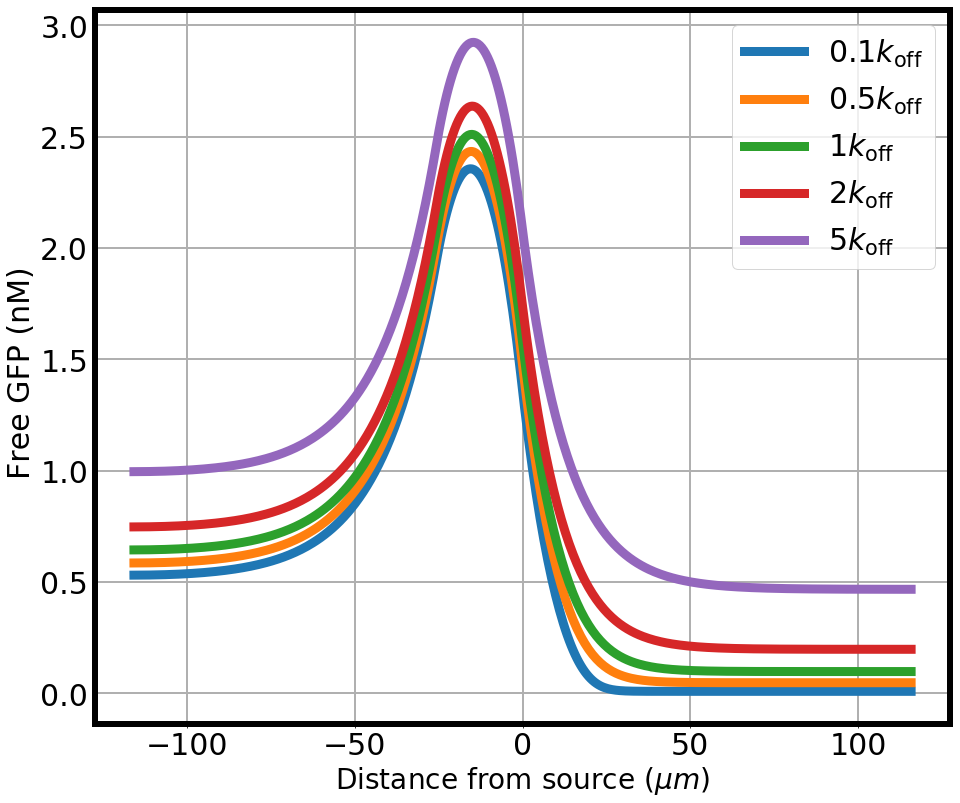

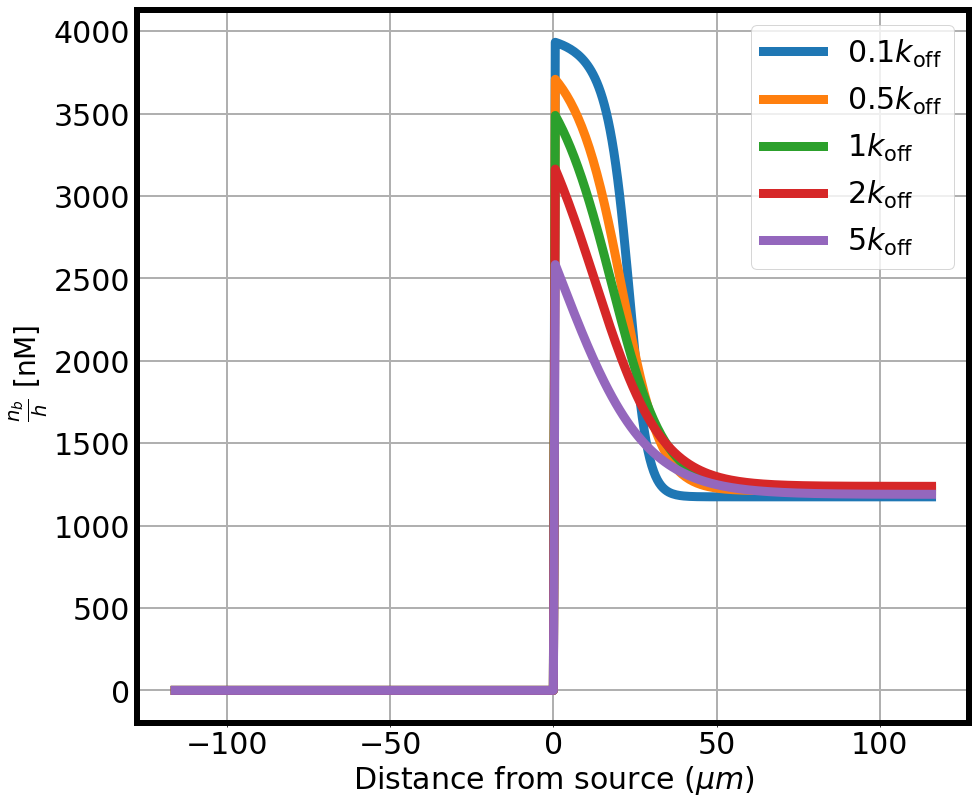

In [15]:
nT = 80 
f=plt.figure(figsize = (13,11))
g=plt.figure(figsize = (13,11))
leg=[]
for i in [0.1,0.5,1,2,5]:
    result_vhh_all_times, result_vhh_all_times_bound =\
    predicted_bound_and_free_GFP_function(J_value,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          i*k_off_value,
                                          jr_value,
                                          kappa_H_value,
                                          source_size_value,
                                          k_H_value)

    plt.figure(f.number)
    plt.plot(x_array,result_vhh_all_times[-1,:], lw=9,ms = 10)
    leg.append(str(i) + r'$k_{\rm{off}}$')
    plt.figure(g.number)
    plt.plot(x_array,result_vhh_all_times_bound[-1,:]/h_value, lw=9,ms = 10)
plt.figure(f.number)
plt.ylabel(r"Free GFP (nM) ",fontsize =30)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =28)
plt.grid(lw=2)
plt.tight_layout()    
plt.legend(leg,fontsize=30)
plt.tick_params(labelsize=30)
ax=plt.gca()
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(6)
plt.savefig('./Figures/fig_S5-J.eps',format='eps',dpi=600)
plt.figure(g.number)
plt.ylabel(r"$\frac{n_b}{h}$ [nM]  ",fontsize =28)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =30)
plt.grid(lw=2)
plt.tight_layout()    
plt.legend(leg,fontsize=30)
plt.tick_params(labelsize=30)
ax2=plt.gca()
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
plt.savefig('./Figures/fig_S5-K.eps',format='eps',dpi=600)

## Figure S6A Effect of changing strength of the source : 


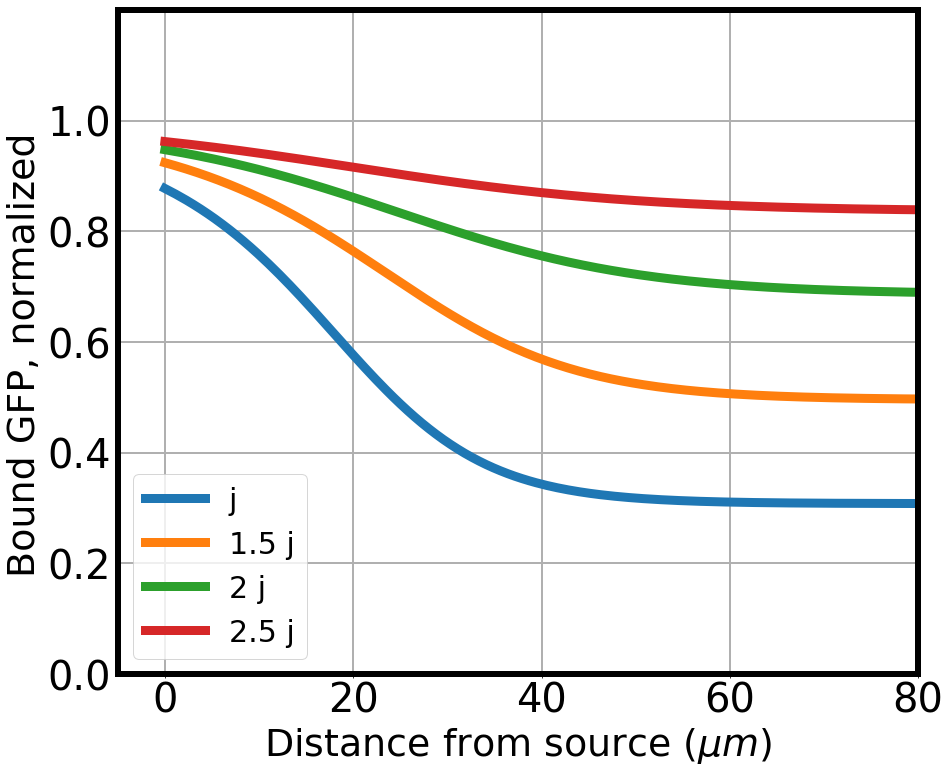

In [35]:
nT_value = 1
plt.figure(figsize = (13,11))
leg=[]
for jp in [J_value, 1.5*J_value, 2*J_value, 2.5*J_value] : 
    result = predicted_bound_GFP_function(vhh['distance'][7:]-vhh['distance'][7],
                                          vhh['signal_mean'][7:],
                                          jp,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          jr_value,
                                          kappa_H_value,
                                          source_size_value,
                                          k_H_value,precision)
    plt.plot(vhh['distance'][7:]-vhh['distance'][7],
             result,
             label = "Bound GFP",
             lw=9,
             ms = 10)
    leg.append("j="+str(jp))
plt.ylabel(r"Bound GFP, normalized  ", fontsize =38)
plt.xlabel(r"Distance from source $(\mu m) $", fontsize =38)
plt.yticks([0, 0.2,0.4,0.6,0.8,1.0])
plt.tick_params(labelsize=40)
plt.grid(lw=2)
plt.tight_layout()    
plt.legend(['j',r'1.5 j',r'2 j',r'2.5 j'], prop={'size': 30})
plt.ylim(0,1.2)
plt.xlim(-5,80)
ax2=plt.gca()
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
plt.savefig('./Figures/fig_S6-A.eps',format='eps',dpi=600)

## Part 2 : Fitting the parameters 

## a) Minimization through the Nelder-Mead method

In [43]:
# We first define the function that we minimize during the fit  : 
def curve_fit_function_minimization(x_data_vhh,
                                    c_data_vhh,
                                    x_data_fat_body,
                                    c_data_fat_body,
                                     x_data_lag3,
                                    c_data_lag3,
                                    J, D, h,
                                    k_on,
                                    k_off,
                                    k_on_lag3,
                                    k_off_lag3,
                                    jr,
                                    kappa_H,
                                    source_size,
                                    k_H,
                                    k_H_fat_body):
    predicted_bound_GFP_vhh =\
    predicted_bound_GFP_function(x_data_vhh,
                                 c_data_vhh['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision)
    predicted_bound_GFP_fat_body =\
    predicted_bound_GFP_function(x_data_fat_body,
                                 c_data_fat_body['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H_fat_body,
                                 precision)
    predicted_bound_GFP_lag3 =\
    predicted_bound_GFP_function(x_data_lag3,
                                 c_data_lag3['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on_lag3,
                                 k_off_lag3,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision)
    #calculate the mean of the vhh experiment 
    #this is used to compare different curves
    sim_mean = np.mean(predicted_bound_GFP_vhh)
    exp_mean = np.mean(vhh['signal_mean'][7:211])
    #calculate differences for each individual experimental curves 
    #(11 vor vhh, 7 for the fat body trap, and 10 for lag3)
    diff_vhh=[];
    diff_lag3=[];
    diff_fat_body=[];
    for i in range(11):
        if i!=4 : 
            diff_vhh.append(predicted_bound_GFP_vhh
                            / sim_mean
                            - c_data_vhh[str(i+1)][7:211]
                            /exp_mean)
        else : #special case as this one curve has data on a shorter total length
            diff_vhh.append(predicted_bound_GFP_vhh[:183]
                            / sim_mean
                            - c_data_vhh[str(i+1)][7:190]
                            /exp_mean)
    
    for i in range (7) :
        diff_fat_body.append(predicted_bound_GFP_fat_body
                             / sim_mean
                             - c_data_fat_body[str(i+1)][7:211]
                             / exp_mean)
    
    for i in range (10) :
        diff_lag3.append(predicted_bound_GFP_lag3
                         / sim_mean
                         - c_data_lag3[str(i+1)][7:211]
                         / exp_mean)
    #sum the squares of differences
    diff_vhh=[item for sublist in diff_vhh for item in sublist]
    diff_lag3=[item for sublist in diff_lag3 for item in sublist]
    diff_fat_body=[item for sublist in diff_fat_body for item in sublist]
    diff_tot=np.concatenate((diff_vhh,diff_lag3,diff_fat_body))
    return np.sum(np.square(diff_tot)) 

In [44]:
#initial conditions for the minimization process: format [J, kappa_H, kh, kh_fat_body, jr]
IC = np.array([0.3, 0.075, 0.01, 0.19, 0.0026]) 

res = minimize(lambda x:\
               curve_fit_function_minimization(vhh['distance'][7:211]-vhh['distance'][7],
                                               vhh,
                                               fat_body['distance'][7:211]-fat_body['distance'][7],
                                               fat_body,
                                               lag3['distance'][7:211]-lag3['distance'][7],
                                               lag3,
                                               x[0],
                                               D_value,
                                               h_value,
                                               k_on_value,
                                               k_off_value,
                                               k_on_value_LAG3,
                                               k_off_value_LAG3,
                                               x[4],
                                               x[1],
                                               source_size_value,
                                               x[2],
                                               x[3]),
                                               IC,
                                               method = 'Nelder-Mead',
                                               tol=1e-6)    
result=np.concatenate((IC,res.x,[res.fun]))
print(res.x)

[0.25282098 0.07059693 0.00829865 0.1782822  0.00227269]
0.2528209790978413 0.002272690853540176 0.07059693203528665 0.008298646238236845 0.1782822008398658
40.79095993108456
0.2654620280527334 0.002272690853540176 0.07059693203528665 0.008298646238236845 0.1782822008398658
42.91087901266903
0.2528209790978413 0.002272690853540176 0.07412677863705099 0.008298646238236845 0.1782822008398658
41.52735038544763
0.2528209790978413 0.002272690853540176 0.07059693203528665 0.008713578550148688 0.1782822008398658
40.78007089236927
0.2528209790978413 0.002272690853540176 0.07059693203528665 0.008298646238236845 0.1871963108818591
40.81993311036473
0.2528209790978413 0.002386325396217185 0.07059693203528665 0.008298646238236845 0.1782822008398658
42.64015734488026
0.2401799301429492 0.0023181446706109802 0.07200887067599239 0.008464619163001582 0.1818478448566631
43.83703758965005
0.2591415035752873 0.002284054307807877 0.07094991669546308 0.00834013946942803 0.1791736118440651
41.22939175223124

0.25575435792849827 0.002300268009315337 0.07064610354314728 0.008552285372877314 0.18067240222287728
40.71478304586471
0.25611555527989704 0.002302770490035579 0.07071113430452089 0.008560679161789195 0.18096329180697646
40.71239982634613
0.25623187385418456 0.0023039489860517187 0.0707801517657892 0.008565099512587961 0.1801049204931645
40.71271029132453
0.2562356398490142 0.0023041121180851624 0.07072043984464753 0.00853439097221962 0.18043543494986114
40.71183537593953
0.25667865202414497 0.0023075270254708955 0.07077787170625527 0.008519340794139758 0.18049002570438888
40.71031887090609
0.25622250264109875 0.0023018683503424294 0.07082139346483567 0.008535993367646901 0.18073049879766975
40.713500570085046
0.2566867981640544 0.002308183490035329 0.07106188545238286 0.00854960826988414 0.18106535453966244
40.711803970558094
0.2574424742571898 0.0023120821448794253 0.07089902817891672 0.008557900153160793 0.18075336305782674
40.70608228196014
0.2584978721217037 0.00231930462137166 0

0.29518135053561684 0.002567059798529869 0.07491221142886335 0.009638231956224486 0.19008811158267389
40.61096997708255
0.2973454674583827 0.0025841429016528633 0.07464213956478877 0.00972259333826362 0.19018480729316034
40.59968660811194
0.29747664438345345 0.002589037073731547 0.07488825831745816 0.009758844763342168 0.1902231981014756
40.60315196192356
0.29716279273428436 0.002584905868659374 0.07481493026441825 0.009733265416637181 0.1901952335038064
40.60026169749074
0.3013245382180342 0.002612792389159219 0.07541118591337706 0.00987112045539169 0.19194509356824946
40.59881894517457
0.30268123980961925 0.0026190330580589337 0.07529946288020054 0.009922854815103077 0.19113706083784443
40.597591217710956
0.30655226271958447 0.0026435633404178665 0.07560616703124845 0.010064650283228348 0.19153007190311
40.600043512550585
0.29705803160587074 0.0025786737214914643 0.0746754788100803 0.009770430622728497 0.1906126220236592
40.59781782249318
0.30102111878971016 0.002604092889059291 0.07

0.3044699571665851 0.002627708408263182 0.0753789174562115 0.009993067059397068 0.19435159120479084
40.59390477663263
0.30445751084920913 0.0026274359341144117 0.07536833720158105 0.009990529137105884 0.19433448347628
40.59388291290641
0.30441900626843 0.0026269504605968353 0.07535142624269445 0.009989753833585035 0.19457832051680599
40.593887396735724
0.3042860758508663 0.0026259424051827893 0.07533075493048264 0.009990520951443878 0.1946186823955764
40.59392051853354
0.3044828224945392 0.0026274757933215016 0.07536476567069897 0.009988304383023708 0.19432976392607923
40.59387886600575
0.30437124178612646 0.002626433804620577 0.07536216725854732 0.009992445182069955 0.19445910960870574
40.5938758840434
0.30432244561788524 0.002625905763862334 0.07536803784342122 0.009995466684009555 0.19450118722488635
40.59389978186413
0.3044019638473838 0.0026267665677703004 0.07536546351099352 0.009990170066069642 0.19420805910500435
40.59388671301862
0.30440622445264537 0.002626812540976934 0.0753

0.3044009886619363 0.0026267756628615673 0.0753617761624108 0.009989823710345923 0.1944221046334619
40.59387025875009
0.30434129085345224 0.0026263855634264307 0.07535595579190996 0.00998800879247103 0.19438818414982306
40.59387009203603
0.30435989918041423 0.0026265244059594413 0.0753580209422874 0.009988283723307343 0.19438393097351495
40.59387011617802
0.30435806551900635 0.002626538860020835 0.0753589178638619 0.009988226890812427 0.1943808789562164
40.593870222847016
0.30435856283658713 0.0026264922829409556 0.07535735290070031 0.009988510462914097 0.19439736214130127
40.59387006479376
0.3043596388313152 0.0026264963660424766 0.07535839690671758 0.009988642968299752 0.19439563032409996
40.59387001436079
0.30432633971715406 0.0026262907137506422 0.07535420193008646 0.009987241840268585 0.19438752716390328
40.59387003130087
0.3043349539640899 0.002626326934272354 0.07535530062719571 0.009987926433193592 0.194402967029165
40.593870088520646
0.3043510275353069 0.0026264423251437337 0.

0.3043607426829076 0.002626519397414395 0.07535906534967038 0.009988278215080002 0.19439710885860664
40.593869830256054
0.30436181542395124 0.0026265267872665273 0.07535924194821726 0.00998831661422215 0.1943969555074374
40.59386984256427
0.30436211130928287 0.002626529308212613 0.07535925476672276 0.009988317981532237 0.1943970178692505
40.593869879047006
0.3043612190805443 0.0026265228483502885 0.07535913515955431 0.009988295260437794 0.19439688517498943
40.593869845623175
0.30436181389970335 0.0026265271549251717 0.07535921489766662 0.00998831040783409 0.19439697363783015
40.59386987147012
0.30436136778533407 0.0026265239249940093 0.07535915509408239 0.009988299047286868 0.1943969072906996
40.593869836639186
0.3043610385008495 0.002626522071099926 0.07535907336734969 0.009988282027275624 0.1943968840186871
40.59386986560163
0.3043616211931758 0.002626525608224877 0.07535919980300038 0.009988307967485517 0.19439693763524984
40.59386985473268
0.3043616124920442 0.002626525528345364 0.

## b) Bootstrapping : 
We perform bootstrapping via the method of residuals. 
It consists in generating artificial data from the previous fit, and then fit new parameters to this artificial data. 
By repeating this process many times (n=1000 for the paper), we get a distribution of fitted parameters informs us about the reliability of our fitting process. 
In the following we showcase the method for one particular realization : 

In [24]:
#First we generate the fit for the 3 conditions vhh,vhh and fat body trap, lag3 : 
result_vhh=\
predicted_bound_GFP_function(vhh['distance'][7:211]-vhh['distance'][7],
                             vhh['signal_mean'][7:211],
                             J_value,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_value,precision)
m=np.mean(result_vhh) 
#results are normalized by the mean of the vhh case 
#so we can compare simulated data and normalized experimental data
result_vhh=result_vhh/m
result_fat_body=\
predicted_bound_GFP_function(fat_body['distance'][7:211]-fat_body['distance'][7],
                             fat_body['signal_mean'][7:211],
                             J_value,
                             D_value,
                             h_value,
                             k_on_value,
                             k_off_value,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_fat_body_value,precision)
#results are normalized by the mean of the vhh case so we can compare simulated data and normalized experimental data 
result_fat_body=result_fat_body/m
result_lag3=\
predicted_bound_GFP_function(vhh['distance'][7:211]-vhh['distance'][7],
                             vhh['signal_mean'][7:211],
                             J_value,
                             D_value,
                             h_value,
                             k_on_value_LAG3,
                             k_off_value_LAG3,
                             jr_value,
                             kappa_H_value,
                             source_size_value,
                             k_H_value,precision)
#results are normalized by the mean of the vhh case so we can compare simulated data and normalized experimental data 
result_lag3=result_lag3/m

In [25]:
#Then for each individual experimental curve we create residuals :
residuals_vhh=[]
for i in range(11):
    if i!=4 : #special case because the 4th experimental vhh curve is shorter than the others
        residuals_vhh.append(vhh[str(i+1)][7:211]
                             /np.mean(vhh['signal_mean'][7:211])
                             -result_vhh)    
    else: 
        residuals_vhh.append(vhh[str(i+1)][7:190]
                             /np.mean(vhh['signal_mean'][7:211])
                             -result_vhh[:183])    

residuals_lag3=[]
for i in range(10):
    residuals_lag3.append(lag3[str(i+1)][7:211]
                          /np.mean(vhh['signal_mean'][7:211])
                          -result_lag3)
    
residuals_fat_body=[]
for i in range(7):
    residuals_fat_body.append(fat_body[str(i+1)][7:211]
                              /np.mean(vhh['signal_mean'][7:211])
                              -result_fat_body)                         

vhh_bt=result_vhh.copy();
lag3_bt=result_lag3.copy();
fat_body_bt=result_fat_body.copy();

residuals_vhh=[item for sublist in residuals_vhh for item in sublist] 
residuals_fat_body=[item for sublist in residuals_fat_body for item in sublist] 
residuals_lag3=[item for sublist in residuals_lag3 for item in sublist]    

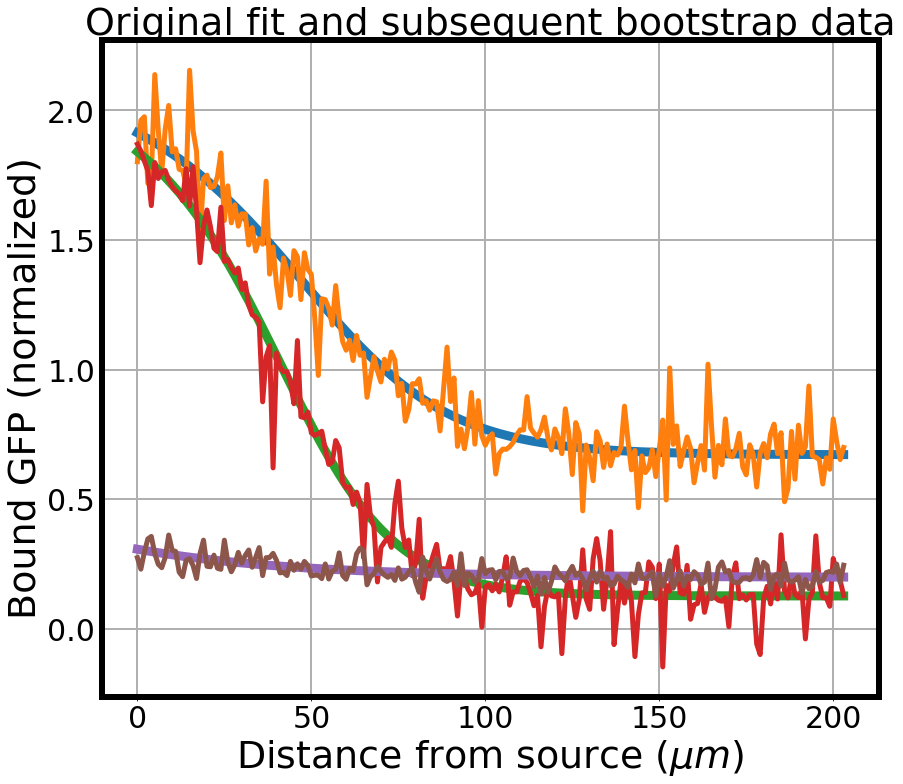

In [26]:
#We generate  bootstrapping data by adding randomly sampled residuals to the fitted data. 
#We then redo the minimization procedure on the newly created data.
#This is done for gen=1 here, but in practice we generate 1000 sets of data 
#(for gen in [0,1000]) and look at the distribution in the fitted parameters.
import random 
gen=1
random.seed(gen)

for i in range(len(result_vhh)) : 
    vhh_bt[i]=result_vhh[i]+random.choice(residuals_vhh)
    
for i in range(len(result_lag3)) : 
    lag3_bt[i]=result_lag3[i]+random.choice(residuals_lag3)

for i in range(len(result_vhh)) : 
    fat_body_bt[i]=result_fat_body[i]+random.choice(residuals_fat_body)
    
plt.figure(figsize = (13,11))
plt.plot(result_vhh, lw=9, ms = 10)
plt.plot(vhh_bt, lw=5, ms = 10)
plt.plot(result_fat_body, lw=9, ms = 10)
plt.plot(fat_body_bt, lw=5, ms = 10)
plt.plot(result_lag3, lw=9, ms = 10)
plt.plot(lag3_bt, lw=5, ms = 10)
plt.ylabel(r"Bound GFP (normalized)   ",fontsize =38)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =38)
plt.tick_params(labelsize=30)
plt.title('Original fit and subsequent bootstrap data',fontsize =38)
plt.grid(lw=2)
plt.tight_layout()    
ax2=plt.gca()
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)

In [28]:
#We redefine a slightly different curve fitting function because we have only 3 curves now
def curve_fit_function_bootstrapping(x_data_vhh,
                                     c_data_vhh,
                                     x_data_fat_body,
                                     c_data_fat_body,
                                     x_data_lag3,
                                     c_data_lag3,
                                     J, D, h,
                                     k_on,
                                     k_off,
                                     k_on_lag3,
                                     k_off_lag3,
                                     jr,
                                     kappa_H,
                                     source_size,
                                     k_H,
                                     k_H_fat_body):
    predicted_bound_GFP_vhh = predicted_bound_GFP_function(x_data_vhh,
                                                           c_data_vhh,
                                                           J, 
                                                           D,
                                                           h,
                                                           k_on,
                                                           k_off,
                                                           jr,
                                                           kappa_H,
                                                           source_size,
                                                           k_H,precision)
    predicted_bound_GFP_fat_body = predicted_bound_GFP_function(x_data_fat_body,
                                                                c_data_fat_body,
                                                                J, 
                                                                D,
                                                                h,
                                                                k_on,
                                                                k_off,
                                                                jr,
                                                                kappa_H,
                                                                source_size,
                                                                k_H_fat_body,precision)
    predicted_bound_GFP_lag3 = predicted_bound_GFP_function(x_data_lag3,
                                                            c_data_lag3,
                                                            J, 
                                                            D,
                                                            h,
                                                            k_on_lag3,
                                                            k_off_lag3,
                                                            jr,
                                                            kappa_H,
                                                            source_size,
                                                            k_H,precision)
    #calculate the mean of the vhh experiment
    #this is used to compare different curves
    sim_mean = np.mean(predicted_bound_GFP_vhh)
    exp_mean = np.mean(c_data_vhh)
    #calculate differences
    diff_vhh = (predicted_bound_GFP_vhh / sim_mean - c_data_vhh / exp_mean)
    diff_fat_body = (predicted_bound_GFP_fat_body / sim_mean - c_data_fat_body / exp_mean)
    diff_lag3 = (predicted_bound_GFP_lag3/ sim_mean - c_data_lag3 / exp_mean)
    #sum the squares of differences
    return np.sum(np.square(diff_vhh) + np.square(diff_fat_body)+ np.square(diff_lag3))

In [29]:
IC=res.x #we use the result for the fit with experimental data as initial condition


res2 =\
minimize(lambda x:\
curve_fit_function_bootstrapping(vhh['distance'][7:211]-vhh['distance'][7],
                                 vhh_bt,
                                 fat_body['distance'][7:211]-fat_body['distance'][7],
                                 fat_body_bt,
                                 lag3['distance'][7:211]-lag3['distance'][7],
                                 lag3_bt,
                                 x[0],
                                 D_value,
                                 h_value,
                                 k_on_value,
                                 k_off_value,
                                 k_on_value_LAG3,
                                 k_off_value_LAG3,
                                 x[4],
                                 x[1],
                                 source_size_value,
                                 x[2],
                                 x[3]),
                                 IC,
                                 method = 'Nelder-Mead',
                                 tol=1e-5)

result=np.concatenate((res2.x,
                       [res.fun],
                       vhh_bt,
                       fat_body_bt,
                       lag3_bt))
print('fit result for this dataset', res2.x)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


fit result for this dataset [0.28297474 0.07675378 0.00971924 0.18162689 0.00250361]
